In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
    compress_repeated_epochs
)
from ripple_heterogeneity.readout import assembly_multi_region, assembly_multi_region_pos_maps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
import nelpy as nel
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
import glob
import pickle
import itertools
from ripple_heterogeneity.place_cells import maps
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [132]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
113,Z:\Data\Kenji\i01_maze15_MS.001_004
114,Z:\Data\Kenji\nlx_070329
115,Z:\Data\ORproject\OR18\day1
116,Z:\Data\ORproject\OR18\day2


In [2]:
save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_v1")

batch_analysis.run(
    sessions,
    save_path,
    assembly_multi_region_pos_maps.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
# load results
# prop_df, assembly_df, df_strength = assembly_multi_region_pos_maps.load_results(save_path)



In [19]:
from ripple_heterogeneity.assembly import assembly_reactivation

regions="CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC"
putativeCellType="Pyr"
weight_dt=0.1  # dt in seconds for binning st to get weights for each assembly
z_mat_dt=0.03  # dt in seconds for binning st to get activation strength
verbose=False  # print out progress
env="linear"
s_binsize=3
sigma=3
speed_thres = 4

basepath = r"Z:\Data\AYAold\AYA7\day19"
m1 = assembly_reactivation.AssemblyReact(
    basepath,
    brainRegion=regions,
    putativeCellType=putativeCellType,
    weight_dt=weight_dt,
    z_mat_dt=z_mat_dt,
)
m1.load_data()
task_idx = assembly_multi_region_pos_maps.locate_task_epoch(m1,env)
m1.get_weights(m1.epochs[task_idx])
assembly_act_task = m1.get_assembly_act(epoch=m1.epochs[task_idx])

pos, outbound_epochs, inbound_epochs = assembly_multi_region_pos_maps.get_pos(basepath, m1, task_idx)

In [25]:
ext_xmin, ext_xmax = (
    np.floor(pos.data[0].min() / 10) * 10,
    np.ceil(pos.data[0].max() / 10) * 10,
)
n_extern = int((ext_xmax - ext_xmin) / s_binsize)

In [112]:
assembly_act_task.unit_ids = np.arange(assembly_act_task.n_signals)
assembly_act_task.unit_labels = None
assembly_act_task.unit_tags = None
assembly_act_task._bin_centers = assembly_act_task.abscissa_vals
assembly_act_task.bin_centers = assembly_act_task.abscissa_vals
assembly_act_task.ds = 1

tc = nel.TuningCurve1D(
    bst=assembly_act_task,
    extern=pos,
    n_extern=n_extern,
    extmin=ext_xmin,
    extmax=ext_xmax,
    sigma=0,
    min_duration=0,
)

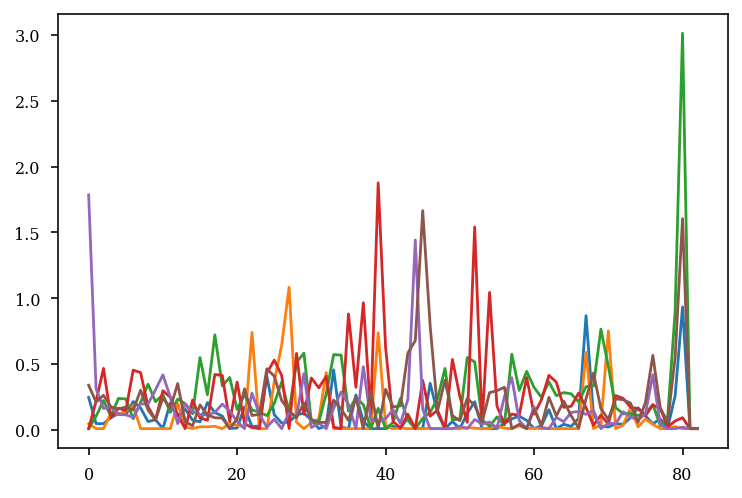

In [113]:
plt.plot(tc.ratemap.T)

In [115]:
tsdframe = nap.TsdFrame(t=assembly_act_task.abscissa_vals, d=assembly_act_task.data.T)

feature = nap.Tsd(t=pos.abscissa_vals, d=pos.data[0])

tc = nap.compute_1d_tuning_curves_continous(tsdframe, feature, nb_bins=n_extern,minmax=[ext_xmin,ext_xmax])


In [128]:
assembly_act_task.n_signals

6

<AxesSubplot:>

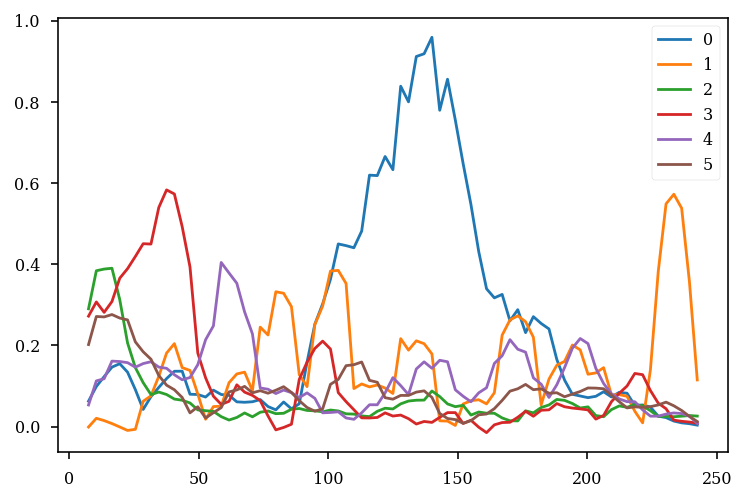

In [127]:
# tc.interpolate(method='cubic').plot()
smooth = tc.rolling(window=5, win_type='gaussian', center=True).mean(std=3) 
smooth.plot()

<AxesSubplot:>

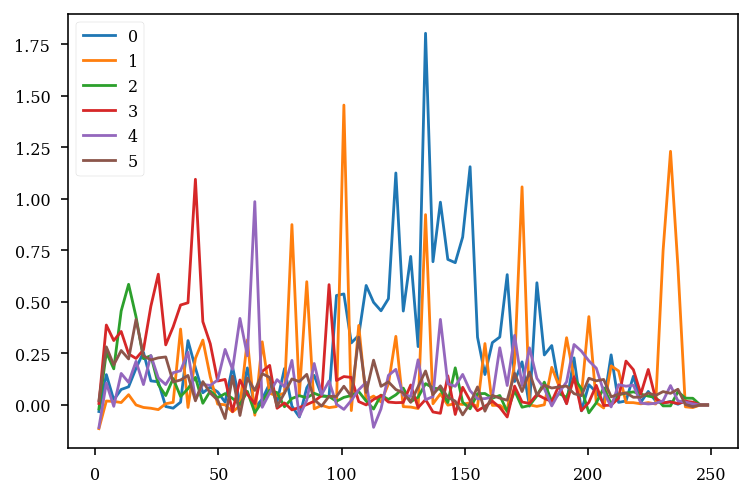

In [111]:
tc.plot()

In [42]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
113,Z:\Data\Kenji\i01_maze15_MS.001_004
114,Z:\Data\Kenji\nlx_070329
115,Z:\Data\ORproject\OR18\day1
116,Z:\Data\ORproject\OR18\day2


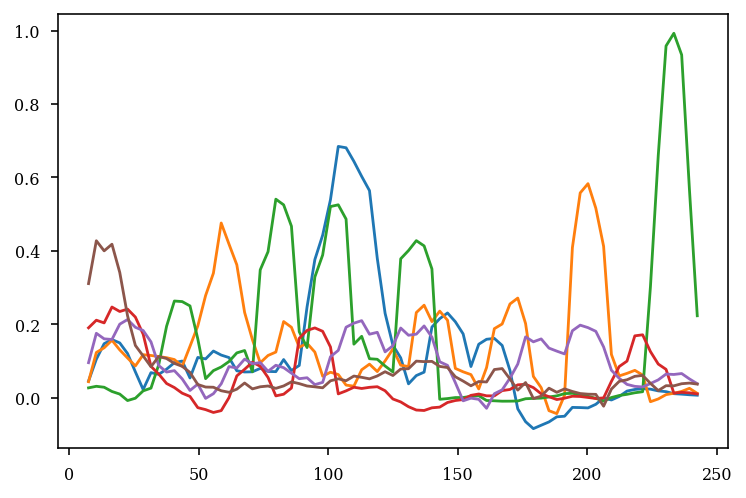

AttributeError: 'AssemblyReact' object has no attribute 'get'

In [131]:
assembly_multi_region_pos_maps.run(r"Z:\Data\AYAold\AYA7\day19")


In [13]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_20ms_dt_sleep_compress_v2"
sessions = glob.glob(save_path + os.sep + "*.pkl")
sessions_df = pd.DataFrame()
sessions_df["basepath"] = sessions

In [ ]:
loading.load_epoch(r"Z:\Data\Kenji\i01_maze01_MS.001_003")


## testing below

In [34]:
epoch_df = pd.DataFrame()
for session in sessions_df["basepath"]:
    with open(session, "rb") as f:
        results = pickle.load(f)
    if results is None:
        continue
    epoch_df_ = loading.load_epoch(results['react'].basepath)

    df_temp_regions = pd.DataFrame()
    df_temp_regions["regions"] = loading.load_brain_regions(results['react'].basepath).keys()
    epoch_df_["mec"] = df_temp_regions.regions.str.contains("EC1|EC2|EC3|EC4|EC5|MEC").any()
    epoch_df_["pfc"] = df_temp_regions.regions.str.contains("PFC").any()

    epoch_df_["basepath"] = results['react'].basepath
    epoch_df = pd.concat([epoch_df,epoch_df_],ignore_index=True)

epoch_df.fillna('', inplace=True)
epoch_df.behavioralParadigm = epoch_df.behavioralParadigm.astype(str)
epoch_df.notes = epoch_df.notes.astype(str)
epoch_df.name = epoch_df.name.astype(str)

epoch_df

,name,startTime,stopTime,environment,behavioralParadigm,notes,mec,pfc,basepath
0,pre,2335.0008,9084.99920,sleep,1,na,True,False,Z:\Data\AYAold\AYA7\day19
1,task,9085.3016,12899.99920,linear,1,novel,True,False,Z:\Data\AYAold\AYA7\day19
2,post,12900.2328,19476.99920,sleep,1,na,True,False,Z:\Data\AYAold\AYA7\day19
3,task2,19487.9984,22969.99920,linear,2,na,True,False,Z:\Data\AYAold\AYA7\day19
4,pre,2273.6552,9603.43120,sleep,2,na,True,False,Z:\Data\AYAold\AYA7\day20
...,...,...,...,...,...,...,...,...,...
1091,OR18day2_sleep2_180124_211028,15817.6640,20855.58395,sleep,,,False,True,Z:\Data\ORproject\OR18\day2
1092,OR18day3_preSleep_180125_092951,0.0000,7938.20795,sleep,,,False,True,Z:\Data\ORproject\OR18\day3
1093,OR18day3_1_180125_150319,7938.2080,9794.62395,wmaze,,,False,True,Z:\Data\ORproject\OR18\day3
1094,OR18day3_2_180125_194109,9794.6240,11726.59195,wmaze,,,False,True,Z:\Data\ORproject\OR18\day3


In [35]:
epoch_df.query("behavioralParadigm == 'novel'")

,name,startTime,stopTime,environment,behavioralParadigm,notes,mec,pfc,basepath
117,maze_210411_095201,9544.5632,11752.80635,linear,novel,novel,True,True,Z:\Data\HMC1\day8


In [36]:
epoch_df.behavioralParadigm.unique()

array(['1', '2', '3', '4', 'nan', '', 'Spontaneous alternation task',
       'Working memory task', '[]', ' Spontaneous alternation task',
       'novel', '10', '7', '8', '9', '6'], dtype=object)

In [409]:
epoch_df[epoch_df.basepath == "Z:\Data\FujisawaS\EE\EE0622fm"]

epoch_df_ = compress_repeated_epochs.main(epoch_df[epoch_df.basepath == "Z:\Data\FujisawaS\EE\EE0622fm"], epoch_name="sleep")
display(epoch_df_)
idx = functions.find_pre_task_post(epoch_df_.environment)

idx

,name,startTime,stopTime,environment,behavioralParadigm,notes,mec,pfc,basepath
0,EE.042,0.0,995.9384,sleep,NaN,NaN,False,True,Z:\Data\FujisawaS\EE\EE0622fm
1,EE.045,995.9384,3336.3928,tmaze,Spontaneous alternation task,NaN,False,True,Z:\Data\FujisawaS\EE\EE0622fm
2,EE.046,3336.3928,5722.444,sleep,NaN,NaN,False,True,Z:\Data\FujisawaS\EE\EE0622fm
3,EE.049,5722.444,7511.244,tmaze,Working memory task,NaN,False,True,Z:\Data\FujisawaS\EE\EE0622fm
4,EE.050,7511.244,9387.644,sleep,NaN,NaN,False,True,Z:\Data\FujisawaS\EE\EE0622fm


(array([ True,  True,  True, False, False]), [0, 1, 2])

In [394]:
import scipy.io as sio
data = sio.loadmat(r"Z:\Data\FujisawaS\EE\EE0622fm\EE0622fm.session.mat",simplify_cells=True)
pd.DataFrame(data["session"]["epochs"])

,name,startTime,stopTime,environment,behavioralParadigm,notes
0,EE.042,0.0000,993.0000,sleep,NaN,NaN
1,EE.043,993.0000,994.6384,sleep,NaN,NaN
2,EE.044,994.6384,995.9384,sleep,NaN,NaN
3,EE.045,995.9384,3336.3928,tmaze,Spontaneous alternation task,NaN
4,EE.046,3336.3928,3476.4760,sleep,NaN,NaN
5,EE.047,3476.4760,4686.8440,sleep,NaN,bad epoch bad HPC signal
6,EE.048,4686.8440,5722.4440,sleep,NaN,NaN
7,EE.049,5722.4440,7511.2440,tmaze,Working memory task,NaN
8,EE.050,7511.2440,9387.6440,sleep,NaN,NaN


In [37]:
print(epoch_df.query("mec").environment.unique())
print("")
print(epoch_df.query("pfc").environment.unique())


['sleep' 'linear' 'cheeseboard' 'box' 'bigSquare' 'wheel' 'Mwheel' 'plus'
 'midSquare' 'bigSquarePlus' 'wheel_home' 'ZigZag']

['sleep' 'tmaze' 'linear' 'wmaze' 'test']


In [39]:
epoch_df.query("environment == 'linear' & pfc")

,name,startTime,stopTime,environment,behavioralParadigm,notes,mec,pfc,basepath
105,maze_210413_110611,9155.6992,12948.10235,linear,,,True,True,Z:\Data\HMC1\day10
108,maze_210415_103630,11830.5472,13621.22235,linear,,,True,True,Z:\Data\HMC1\day12
111,maze_210416_130639,10570.1312,13029.35035,linear,,,True,True,Z:\Data\HMC1\day13
114,maze_210417_124216,13338.4192,15590.27835,linear,,,True,True,Z:\Data\HMC1\day14
117,maze_210411_095201,9544.5632,11752.80635,linear,novel,novel,True,True,Z:\Data\HMC1\day8
120,maze_210412_100352,12429.9072,15544.23035,linear,,,True,True,Z:\Data\HMC1\day9


In [41]:
epoch_df.query("environment == 'linear' & mec").basepath.unique()


array(['Z:\\Data\\AYAold\\AYA7\\day19', 'Z:\\Data\\AYAold\\AYA7\\day20',
       'Z:\\Data\\AYAold\\AYA7\\day27', 'Z:\\Data\\AYAold\\AYA9\\day12',
       'Z:\\Data\\AYAold\\AYA9\\day17', 'Z:\\Data\\HMC1\\day10',
       'Z:\\Data\\HMC1\\day12', 'Z:\\Data\\HMC1\\day13',
       'Z:\\Data\\HMC1\\day14', 'Z:\\Data\\HMC1\\day8',
       'Z:\\Data\\HMC1\\day9', 'Z:\\Data\\Kenji\\ec013.152_157',
       'Z:\\Data\\Kenji\\ec013.194_213', 'Z:\\Data\\Kenji\\ec013.242_258',
       'Z:\\Data\\Kenji\\ec013.370_390', 'Z:\\Data\\Kenji\\ec013.393_418',
       'Z:\\Data\\Kenji\\ec013.421_447', 'Z:\\Data\\Kenji\\ec013.451_470',
       'Z:\\Data\\Kenji\\ec013.480_509', 'Z:\\Data\\Kenji\\ec013.512_537',
       'Z:\\Data\\Kenji\\ec013.540_561', 'Z:\\Data\\Kenji\\ec013.564_585',
       'Z:\\Data\\Kenji\\ec013.588_604', 'Z:\\Data\\Kenji\\ec013.608_632',
       'Z:\\Data\\Kenji\\ec013.634_653', 'Z:\\Data\\Kenji\\ec013.656_674',
       'Z:\\Data\\Kenji\\ec013.677_699', 'Z:\\Data\\Kenji\\ec013.702_724',
       'Z:\

In [19]:
loading.load_epoch(r"Z:\Data\Kenji\i01_maze01_MS.001_003")

,name,startTime,stopTime,environment,behavioralParadigm
0,i01_maze01_MS.001_sleep,0.0000,1476.4000,sleep,10
1,i01_maze01_MS.002_Mwheel,1476.4000,2398.4096,Mwheel,10
2,i01_maze01_MS.003_sleep,2398.4096,3716.5026,sleep,10


In [3]:
basepath = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_GG_GG0401.pkl"
with open(basepath, "rb") as f:
    results = pickle.load(f)


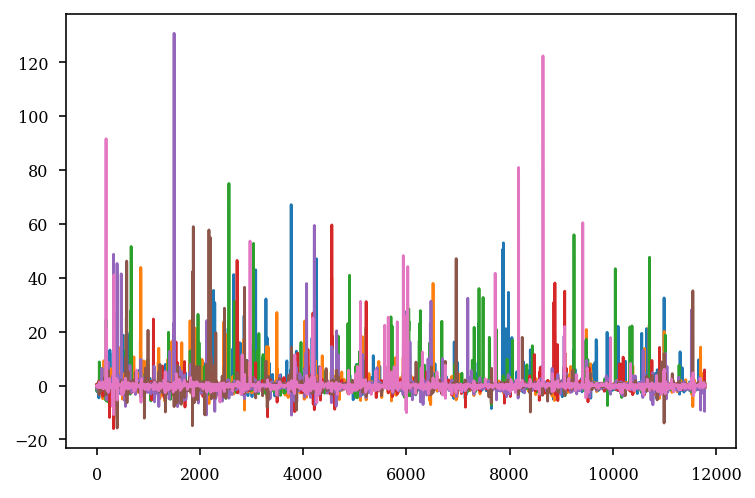

In [4]:
plt.plot(results['assembly_act_task'].data.T)
plt.show()

In [5]:
position_df = loading.load_animal_behavior(results['react'].basepath)

In [6]:
position_df_no_nan = position_df.query("not x.isnull() & not y.isnull()")

pos = nel.PositionArray(data=position_df_no_nan[["x","y"]].values.T,timestamps=position_df_no_nan.timestamps.values)

In [7]:
results["react"].epochs

<EpochArray at 0x1d1156e2ac0: 1 epoch> of length 29:09:999 minutes

In [8]:
assembly_act_task = results["react"].get_assembly_act(epoch=results["react"].epochs[0])

In [9]:
tc = maps.TuningCurve2DContinuous(asa=assembly_act_task, pos=pos,sigma=3)


In [10]:
tc

<TuningCurve2D at 0x1d11ab18100> with shape (7, 38, 35)

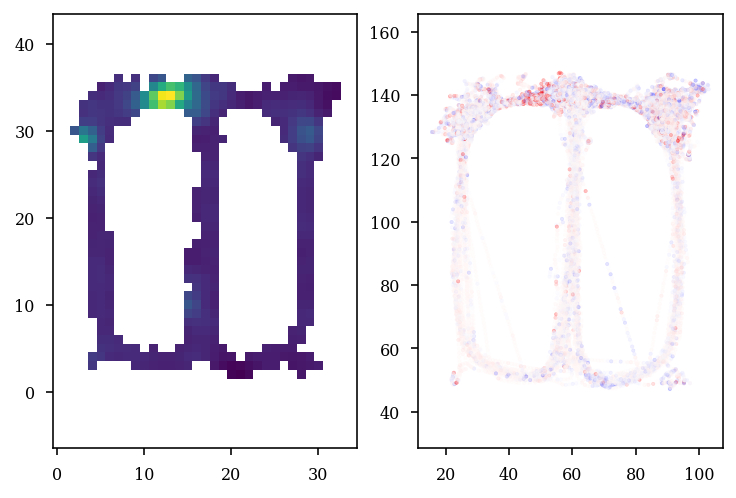

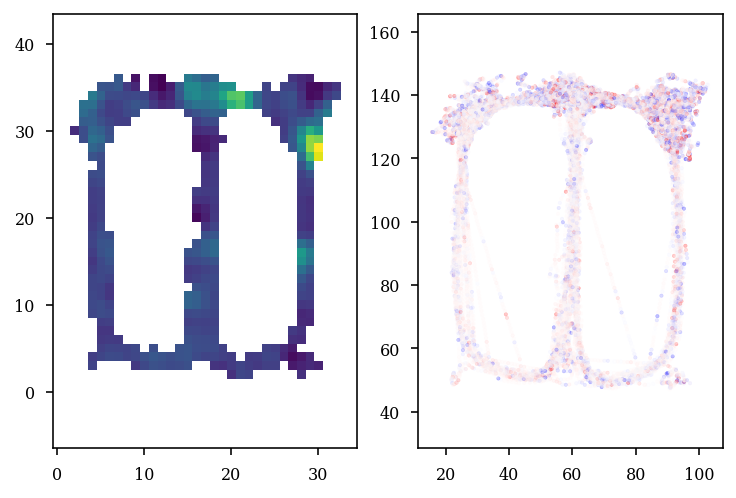

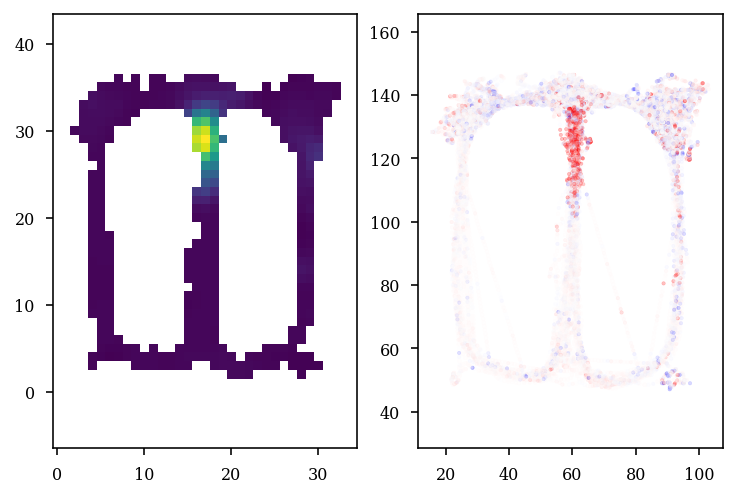

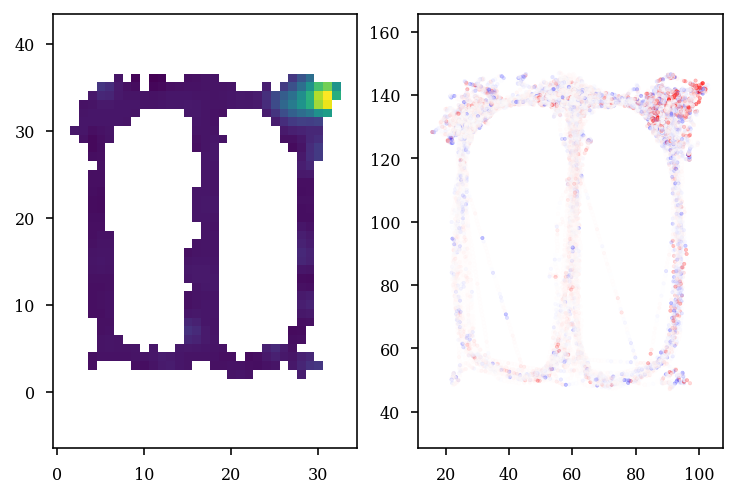

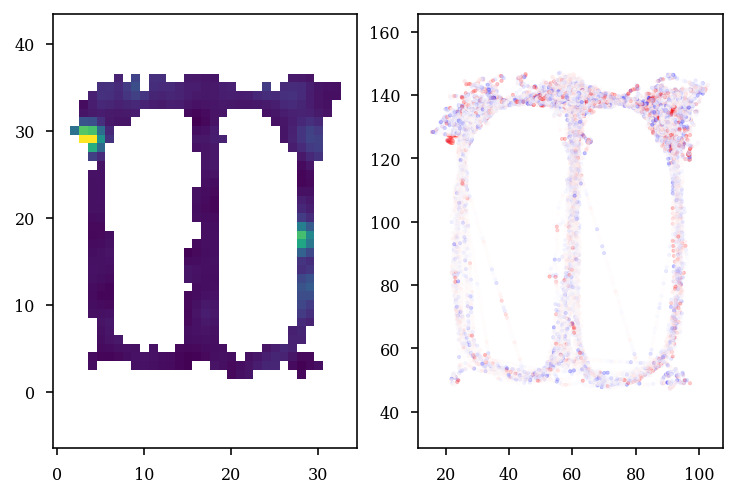

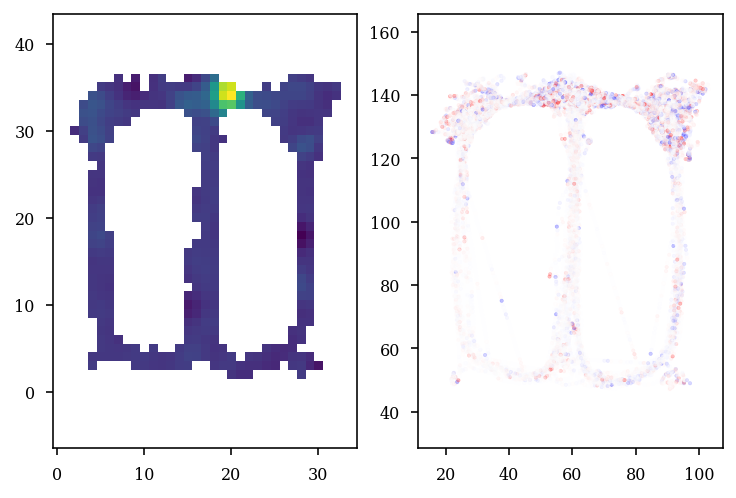

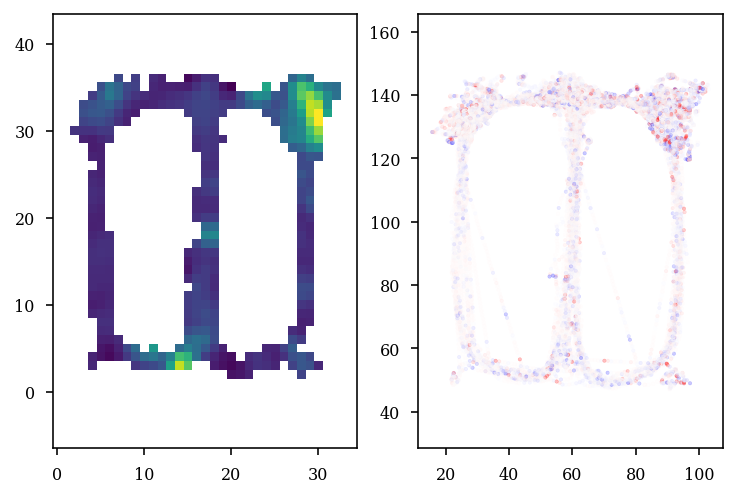

In [11]:
import matplotlib as mpl

position_df_no_nan = position_df.query("not x.isnull()")
norm = mpl.colors.Normalize(vmin=-3, vmax=3)
sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm)

for uu in range(assembly_act_task.n_signals):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(tc.ratemap[uu, :, :], origin="lower")
    # ax[0].colorbar()
    ax[0].axis("equal")

    colors = np.interp(
        position_df_no_nan.time.values,
        assembly_act_task.abscissa_vals,
        assembly_act_task.data[uu],
    )
    ax[1].scatter(
        position_df_no_nan.y,
        position_df_no_nan.x,
        s=3,
        c=colors,
        alpha=0.25,
        cmap="bwr",
        norm=norm,
    )
    ax[1].axis("equal")
    # sm.set_array([])
    # plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    # cax = plt.axes([0.85, 0.1, 0.03, 0.7])
    # cbar = plt.colorbar(sm,cax=cax)


In [356]:
# assembly_act_task_test = copy.deepcopy(assembly_act_task)
# assembly_act_task_test._data = assembly_act_task_test.data + np.abs(np.nanmin(assembly_act_task_test.data))
tc = nel.TuningCurve1D(bst=assembly_act_task,extern=pos,n_extern=n_extern,extmin=ext_xmin,extmax=ext_xmax,sigma=3)

In [354]:
np.nanmin(assembly_act_task_test.data)

0.0

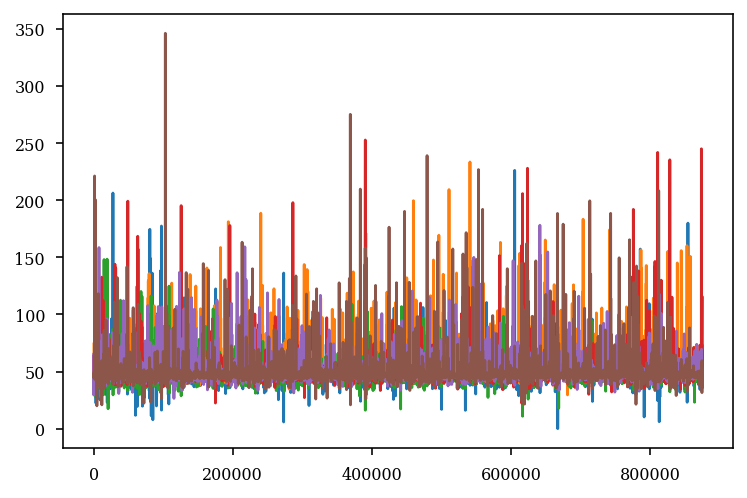

In [351]:
plt.plot(assembly_act_task_test.data.T)
plt.show()

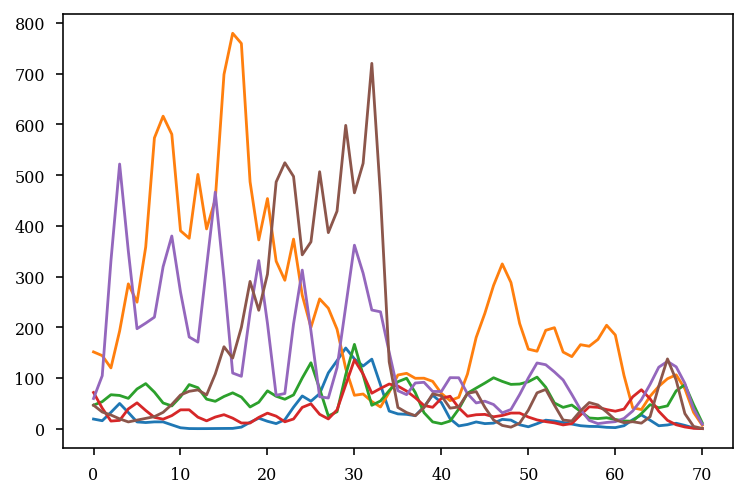

In [357]:
plt.plot(tc.ratemap.T)
plt.show()

In [330]:
pos = nel.PositionArray(data=position_df_no_nan.linearized.values*100+2,timestamps=position_df_no_nan.timestamps.values)
ext_xmin, ext_xmax = np.floor(pos.data[0].min() / 10) * 10, np.ceil(pos.data[0].max() / 10) * 10
n_extern = len(np.arange(ext_xmin, ext_xmax + bin_size, bin_size))


tc = maps.TuningCurve1DContinous(asa=assembly_act_task,extern=pos,n_extern=n_extern,extmin=ext_xmin,extmax=ext_xmax,sigma=3)


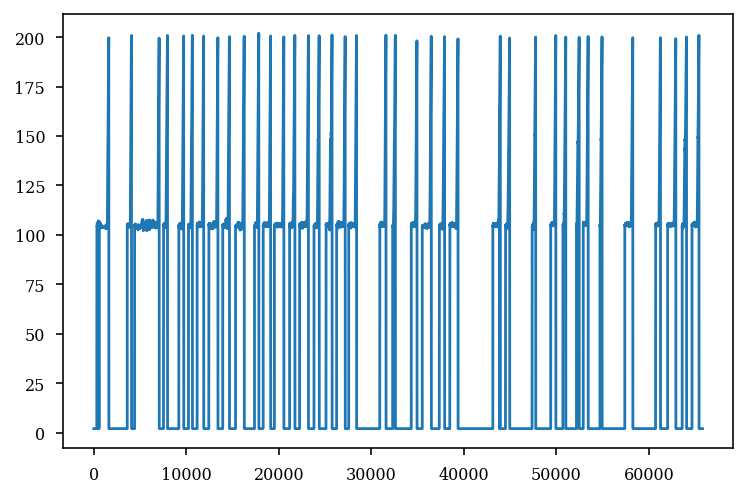

In [327]:
plt.plot(pos.data.T)
plt.show()

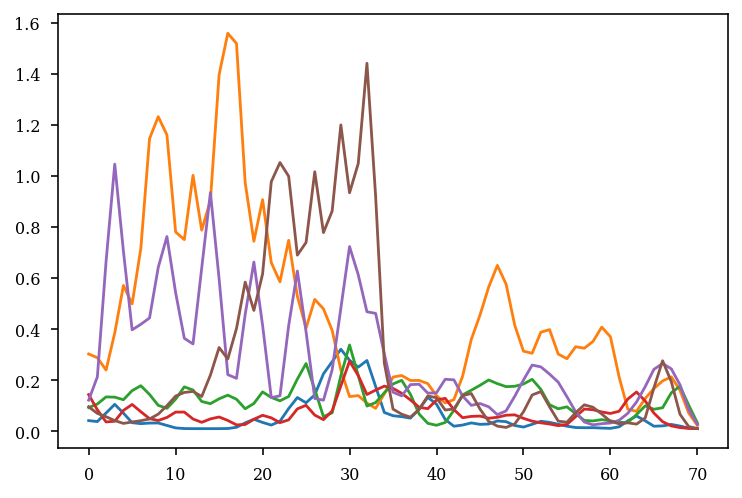

In [331]:
plt.plot(tc.ratemap.T)
plt.show()

In [43]:
x = [-3,-2,0,1,2,3]
x - np.min(x)

array([0, 1, 3, 4, 5, 6])

In [304]:
import copy
########################################################################
# class TuningCurve1D
########################################################################
class TuningCurve1DContinous:
    """Tuning curves (1-dimensional) of multiple signals.
    Get in asa
    Get in queriable object for external correlates
    Get in bins, binlabels
    Get in n_bins, xmin, xmax
    Get in a transform function f
    Parameters
    ----------
    Attributes
    ----------
    """

    __attributes__ = [
        "_ratemap",
        "_occupancy",
        "_signals_ids",
        "_signal_labels",
        "_signal_tags",
        "_label",
    ]

    def __init__(
        self,
        *,
        asa=None,
        extern=None,
        ratemap=None,
        sigma=None,
        truncate=None,
        n_extern=None,
        transform_func=None,
        minbgrate=None,
        extmin=None,
        extmax=None,
        extlabels=None,
        signal_ids=None,
        signal_labels=None,
        signal_tags=None,
        label=None,
        min_duration=None,
        empty=False
    ):
        """
        If sigma is nonzero, then smoothing is applied.
        We always require asa and extern, and then some combination of
            (1) bin edges, transform_func*
            (2) n_extern, transform_func*
            (3) n_extern, x_min, x_max, transform_func*
            transform_func operates on extern and returns a value that TuninCurve1D can interpret. If no transform is specified, the identity operator is assumed.
        """
        # TODO: input validation
        if not empty:
            if ratemap is None:
                assert (
                    asa is not None
                ), "asa must be specified or ratemap must be specified!"
                assert (
                    extern is not None
                ), "extern must be specified or ratemap must be specified!"
            else:
                assert asa is None, "ratemap and asa cannot both be specified!"
                assert extern is None, "ratemap and extern cannot both be specified!"

        # if an empty object is requested, return it:
        if empty:
            for attr in self.__attributes__:
                exec("self." + attr + " = None")
            return

        self._asa = asa
        self._extern = extern

        if minbgrate is None:
            minbgrate = 0.01  # Hz minimum background firing rate

        if n_extern is not None:
            if extmin is not None and extmax is not None:
                self._bins = np.linspace(extmin, extmax, n_extern + 1)
            else:
                raise NotImplementedError
        else:
            raise NotImplementedError

        if min_duration is None:
            min_duration = 0

        self._min_duration = min_duration

        self._signals_ids = np.arange(asa.n_signals)
        self._signal_labels = None
        self._signal_tags = None  # no input validation yet
        self.label = label

        if transform_func is None:
            self.trans_func = self._trans_func

        # compute occupancy
        self._occupancy = self._compute_occupancy()
        # compute ratemap (in Hz)
        self._ratemap = self._compute_ratemap()
        # normalize firing rate by occupancy
        self._ratemap = self._normalize_firing_rate_by_occupancy()
        # enforce minimum background firing rate
        self._ratemap[
            self._ratemap < minbgrate
        ] = minbgrate  # background firing rate of 0.01 Hz

        if sigma is not None:
            if sigma > 0:
                self.smooth(sigma=sigma, truncate=truncate, inplace=True)

        # optionally detach _asa and _extern to save space when pickling, for example
        self._detach()

    @property
    def is2d(self):
        return False

    def spatial_information(self):
        """Compute the spatial information and firing sparsity...
        The specificity index examines the amount of information
        (in bits) that a single spike conveys about the animal's
        location (i.e., how well cell firing predicts the animal's
        location).The spatial information content of cell discharge was
        calculated using the formula:
            information content = \Sum P_i(R_i/R)log_2(R_i/R)
        where i is the bin number, P_i, is the probability for occupancy
        of bin i, R_i, is the mean firing rate for bin i, and R is the
        overall mean firing rate.
        In order to account for the effects of low firing rates (with
        fewer spikes there is a tendency toward higher information
        content) or random bursts of firing, the spike firing
        time-series was randomly offset in time from the rat location
        time-series, and the information content was calculated. A
        distribution of the information content based on 100 such random
        shifts was obtained and was used to compute a standardized score
        (Zscore) of information content for that cell. While the
        distribution is not composed of independent samples, it was
        nominally normally distributed, and a Z value of 2.29 was chosen
        as a cut-off for significance (the equivalent of a one-tailed
        t-test with P = 0.01 under a normal distribution).
        Reference(s)
        ------------
        Markus, E. J., Barnes, C. A., McNaughton, B. L., Gladden, V. L.,
            and Skaggs, W. E. (1994). "Spatial information content and
            reliability of hippocampal CA1 neurons: effects of visual
            input", Hippocampus, 4(4), 410-421.
        Parameters
        ----------
        Returns
        -------
        si : array of shape (n_signals,)
            spatial information (in bits) per unit
        sparsity: array of shape (n_signals,)
            sparsity (in percent) for each unit
        """

        # Pi = self.occupancy / np.sum(self.occupancy)
        # R = self.ratemap.mean(axis=1) # mean firing rate
        # Ri = self.ratemap.T
        # si = np.sum((Pi*((Ri / R)*np.log2(Ri / R)).T), axis=1)

        # sparsity = np.sum((Pi*Ri.T), axis=1)/(R**2)

        return utils.spatial_information(ratemap=self.ratemap)

    def spatial_sparsity(self):
        """Compute the spatial information and firing sparsity...
        The specificity index examines the amount of information
        (in bits) that a single spike conveys about the animal's
        location (i.e., how well cell firing redicts the animals
        location).The spatial information content of cell discharge was
        calculated using the formula:
            information content = \Sum P_i(R_i/R)log_2(R_i/R)
        where i is the bin number, P, is the probability for occupancy
        of bin i, R, is the mean firing rate for bin i, and R is the
        overall mean firing rate.
        In order to account for the effects of low firing rates (with
        fewer spikes there is a tendency toward higher information
        content) or random bursts of firing, the spike firing
        time-series was randomly offset in time from the rat location
        time-series, and the information content was calculated. A
        distribution of the information content based on 100 such random
        shifts was obtained and was used to compute a standardized score
        (Zscore) of information content for that cell. While the
        distribution is not composed of independent samples, it was
        nominally normally distributed, and a Z value of 2.29 was chosen
        as a cut-off for significance (the equivalent of a one-tailed
        t-test with P = 0.01 under a normal distribution).
        Reference(s)
        ------------
        Markus, E. J., Barnes, C. A., McNaughton, B. L., Gladden, V. L.,
            and Skaggs, W. E. (1994). "Spatial information content and
            reliability of hippocampal CA1 neurons: effects of visual
            input", Hippocampus, 4(4), 410-421.
        Parameters
        ----------
        Returns
        -------
        si : array of shape (n_signals,)
            spatial information (in bits) per unit
        sparsity: array of shape (n_signals,)
            sparsity (in percent) for each unit
        """
        return utils.spatial_sparsity(ratemap=self.ratemap)

    def _init_from_ratemap(
        self,
        ratemap,
        occupancy=None,
        extmin=None,
        extmax=None,
        extlabels=None,
        signal_ids=None,
        signal_labels=None,
        signal_tags=None,
        label=None,
    ):
        """Initialize a TuningCurve1D object from a ratemap.
        Parameters
        ----------
        ratemap : array
            Array of shape (n_signals, n_extern)
        Returns
        -------
        """
        n_signals, n_extern = ratemap.shape

        if occupancy is None:
            # assume uniform occupancy
            self._occupancy = np.ones(n_extern)

        if extmin is None:
            extmin = 0
        if extmax is None:
            extmax = extmin + 1

        self._bins = np.linspace(extmin, extmax, n_extern + 1)
        self._ratemap = ratemap

        # inherit unit IDs if available, otherwise initialize to default
        if signal_ids is None:
            signal_ids = list(range(1, n_signals + 1))

        signal_ids = np.array(signal_ids, ndmin=1)  # standardize signal_ids

        # if signal_labels is empty, default to signal_ids
        if signal_labels is None:
            signal_labels = signal_ids

        signal_labels = np.array(signal_labels, ndmin=1)  # standardize

        self._signals_ids = signal_ids
        self._signal_labels = signal_labels
        self._signal_tags = signal_tags  # no input validation yet
        if label is not None:
            self.label = label

        return self

    def mean(self, *, axis=None):
        """Returns the mean of firing rate (in Hz).
        Parameters
        ----------
        axis : int, optional
            When axis is None, the global mean firing rate is returned.
            When axis is 0, the mean firing rates across signal, as a
            function of the external correlate (e.g. position) are
            returned.
            When axis is 1, the mean firing rate for each unit is
            returned.
        Returns
        -------
        mean :
        """
        means = np.mean(self.ratemap, axis=axis).squeeze()
        if means.size == 1:
            return np.asscalar(means)
        return means

    def max(self, *, axis=None):
        """Returns the mean of firing rate (in Hz).
        Parameters
        ----------
        axis : int, optional
            When axis is None, the global mean firing rate is returned.
            When axis is 0, the mean firing rates across signal, as a
            function of the external correlate (e.g. position) are
            returned.
            When axis is 1, the mean firing rate for each unit is
            returned.
        Returns
        -------
        mean :
        """
        maxes = np.max(self.ratemap, axis=axis).squeeze()
        if maxes.size == 1:
            return np.asscalar(maxes)
        return maxes

    def min(self, *, axis=None):
        """Returns the mean of firing rate (in Hz).
        Parameters
        ----------
        axis : int, optional
            When axis is None, the global mean firing rate is returned.
            When axis is 0, the mean firing rates across signal, as a
            function of the external correlate (e.g. position) are
            returned.
            When axis is 1, the mean firing rate for each unit is
            returned.
        Returns
        -------
        mean :
        """
        mins = np.min(self.ratemap, axis=axis).squeeze()
        if mins.size == 1:
            return np.asscalar(mins)
        return mins

    @property
    def ratemap(self):
        return self._ratemap

    @property
    def n_bins(self):
        """(int) Number of external correlates (bins)."""
        return len(self.bins) - 1

    @property
    def occupancy(self):
        return self._occupancy

    @property
    def bins(self):
        """External correlate bins."""
        return self._bins

    @property
    def bin_centers(self):
        """External correlate bin centers."""
        return (self.bins + (self.bins[1] - self.bins[0]) / 2)[:-1]

    def _trans_func(self, extern, at):
        """Default transform function to map extern into numerical bins"""

        _, ext = extern.asarray(at=at)

        return np.atleast_1d(ext)

    def _compute_occupancy(self):

        # Make sure that self._asa_centers fall within not only the support
        # of extern, but also within the extreme sample times; otherwise,
        # interpolation will yield NaNs at the extremes. Indeed, when we have
        # sample times within a support epoch, we can assume that the signal
        # stayed roughly constant for that one sample duration.

        if self._asa._bin_centers[0] < self._extern.time[0]:
            self._extern = copy.copy(self._extern)
            self._extern.time[0] = self._asa._bin_centers[0]
            self._extern._interp = None
            # raise ValueError('interpolated sample requested before first sample of extern!')
        if self._asa._bin_centers[-1] > self._extern.time[-1]:
            self._extern = copy.copy(self._extern)
            self._extern.time[-1] = self._asa._bin_centers[-1]
            self._extern._interp = None
            # raise ValueError('interpolated sample requested after last sample of extern!')

        ext = self.trans_func(self._extern, at=self._asa.bin_centers)

        xmin = self.bins[0]
        xmax = self.bins[-1]
        occupancy, _ = np.histogram(ext, bins=self.bins, range=(xmin, xmax))
        # xbins = (bins + xmax/n_xbins)[:-1] # for plotting
        return occupancy

    def _compute_ratemap(self, min_duration=None):

        if min_duration is None:
            min_duration = self._min_duration

        ext = self.trans_func(self._extern, at=self._asa.bin_centers)

        ext_bin_idx = np.squeeze(np.digitize(ext, self.bins, right=True))
        # make sure that all the events fit between extmin and extmax:
        # TODO: this might rather be a warning, but it's a pretty serious warning...
        if ext_bin_idx.max() > self.n_bins:
            raise ValueError("ext values greater than 'ext_max'")
        if ext_bin_idx.min() == 0:
            raise ValueError("ext values less than 'ext_min'")

        ratemap = np.zeros((self.n_signals, self.n_bins))

        for tt, bidx in enumerate(ext_bin_idx):
            ratemap[:, bidx - 1] += self._asa.data[:, tt]

        # apply minimum observation duration
        for uu in range(self.n_signals):
            ratemap[uu][self.occupancy * self._asa.ds < min_duration] = 0

        return ratemap

    def normalize(self, inplace=False):

        if not inplace:
            out = copy.deepcopy(self)
        else:
            out = self
        if self.n_signals > 1:
            per_unit_max = np.max(out.ratemap, axis=1)[..., np.newaxis]
            out._ratemap = self.ratemap / np.tile(per_unit_max, (1, out.n_bins))
        else:
            per_unit_max = np.max(out.ratemap)
            out._ratemap = self.ratemap / np.tile(per_unit_max, out.n_bins)
        return out

    def _normalize_firing_rate_by_occupancy(self):
        # normalize spike counts by occupancy:
        denom = np.tile(self.occupancy, (self.n_signals, 1))
        denom[denom == 0] = 1
        ratemap = self.ratemap / denom
        return ratemap

    @property
    def signal_ids(self):
        """Unit IDs contained in the SpikeTrain."""
        return list(self._signals_ids)

    @signal_ids.setter
    def signal_ids(self, val):
        if len(val) != self.n_signals:
            # print(len(val))
            # print(self.n_signals)
            raise TypeError("signal_ids must be of length n_signals")
        elif len(set(val)) < len(val):
            raise TypeError("duplicate signal_ids are not allowed")
        else:
            try:
                # cast to int:
                signal_ids = [int(id) for id in val]
            except TypeError:
                raise TypeError("signal_ids must be int-like")
        self._signals_ids = signal_ids

    @property
    def signal_labels(self):
        """Labels corresponding to signal contained in the SpikeTrain."""
        if self._signal_labels is None:
            warnings.warn("unit labels have not yet been specified")
        return self._signal_labels

    @signal_labels.setter
    def signal_labels(self, val):
        if len(val) != self.n_signals:
            raise TypeError("labels must be of length n_signals")
        else:
            try:
                # cast to str:
                labels = [str(label) for label in val]
            except TypeError:
                raise TypeError("labels must be string-like")
        self._signal_labels = labels

    @property
    def signal_tags(self):
        """Tags corresponding to signal contained in the SpikeTrain"""
        if self._signal_tags is None:
            warnings.warn("unit tags have not yet been specified")
        return self._signal_tags

    @property
    def label(self):
        """Label pertaining to the source of the spike train."""
        if self._label is None:
            warnings.warn("label has not yet been specified")
        return self._label

    @label.setter
    def label(self, val):
        if val is not None:
            try:  # cast to str:
                label = str(val)
            except TypeError:
                raise TypeError("cannot convert label to string")
        else:
            label = val
        self._label = label

    def __add__(self, other):
        out = copy.copy(self)

        if isinstance(other, numbers.Number):
            out._ratemap = out.ratemap + other
        elif isinstance(other, TuningCurve1D):
            # TODO: this should merge two TuningCurve1D objects
            raise NotImplementedError
        else:
            raise TypeError(
                "unsupported operand type(s) for +: 'TuningCurve1D' and '{}'".format(
                    str(type(other))
                )
            )
        return out

    def __sub__(self, other):
        out = copy.copy(self)
        out._ratemap = out.ratemap - other
        return out

    def __mul__(self, other):
        """overloaded * operator."""
        out = copy.copy(self)
        out._ratemap = out.ratemap * other
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        """overloaded / operator."""
        out = copy.copy(self)
        out._ratemap = out.ratemap / other
        return out

    def __len__(self):
        return self.n_signals

    def smooth(self, *, sigma=None, truncate=None, inplace=False, mode=None, cval=None):
        """Smooths the tuning curve with a Gaussian kernel.
        mode : {‘reflect’, ‘constant’, ‘nearest’, ‘mirror’, ‘wrap’}, optional
            The mode parameter determines how the array borders are handled,
            where cval is the value when mode is equal to ‘constant’. Default is
            ‘reflect’
        cval : scalar, optional
            Value to fill past edges of input if mode is ‘constant’. Default is 0.0
        """
        if sigma is None:
            sigma = 0.1  # in signal of extern
        if truncate is None:
            truncate = 4
        if mode is None:
            mode = "reflect"
        if cval is None:
            cval = 0.0

        ds = (self.bins[-1] - self.bins[0]) / self.n_bins
        sigma = sigma / ds

        if not inplace:
            out = copy.deepcopy(self)
        else:
            out = self

        if self.n_signals > 1:
            out._ratemap = scipy.ndimage.filters.gaussian_filter(
                self.ratemap, sigma=(0, sigma), truncate=truncate, mode=mode, cval=cval
            )
        else:
            out._ratemap = scipy.ndimage.filters.gaussian_filter(
                self.ratemap, sigma=sigma, truncate=truncate, mode=mode, cval=cval
            )

        return out

    @property
    def n_signals(self):
        """(int) The number of signal."""
        try:
            return len(self._signals_ids)
        except TypeError:  # when signal_ids is an integer
            return 1
        except AttributeError:
            return 0

    @property
    def shape(self):
        """(tuple) The shape of the TuningCurve1D ratemap."""
        if self.isempty:
            return (self.n_signals, 0)
        if len(self.ratemap.shape) == 1:
            return (1, self.ratemap.shape[0])
        return self.ratemap.shape

    def __repr__(self):
        address_str = " at " + str(hex(id(self)))
        if self.isempty:
            return "<empty TuningCurve1D" + address_str + ">"
        shapestr = " with shape (%s, %s)" % (self.shape[0], self.shape[1])
        return "<TuningCurve1D%s>%s" % (address_str, shapestr)

    @property
    def isempty(self):
        """(bool) True if TuningCurve1D is empty"""
        try:
            return len(self.ratemap) == 0
        except TypeError:  # TypeError should happen if ratemap = []
            return True

    def __iter__(self):
        """TuningCurve1D iterator initialization"""
        # initialize the internal index to zero when used as iterator
        self._index = 0
        return self

    def __next__(self):
        """TuningCurve1D iterator advancer."""
        index = self._index
        if index > self.n_signals - 1:
            raise StopIteration
        out = copy.copy(self)
        out._ratemap = self.ratemap[index, :]
        out._signals_ids = self.signal_ids[index]
        out._signal_labels = self.signal_labels[index]
        self._index += 1
        return out

    def __getitem__(self, *idx):
        """TuningCurve1D index access.
        Accepts integers, slices, and lists"""

        idx = [ii for ii in idx]
        if len(idx) == 1 and not isinstance(idx[0], int):
            idx = idx[0]
        if isinstance(idx, tuple):
            idx = [ii for ii in idx]

        if self.isempty:
            return self
        try:
            out = copy.copy(self)
            out._ratemap = self.ratemap[idx, :]
            out._signals_ids = (np.asanyarray(out._signals_ids)[idx]).tolist()
            out._signal_labels = (np.asanyarray(out._signal_labels)[idx]).tolist()
            return out
        except Exception:
            raise TypeError("unsupported subsctipting type {}".format(type(idx)))

    def _unit_subset(self, signal_list):
        """Return a TuningCurve1D restricted to a subset of signal.
        Parameters
        ----------
        signal_list : array-like
            Array or list of signal_ids.
        """
        unit_subset_ids = []
        for unit in signal_list:
            try:
                id = self.signal_ids.index(unit)
            except ValueError:
                warnings.warn(
                    "unit_id " + str(unit) + " not found in TuningCurve1D; ignoring"
                )
                pass
            else:
                unit_subset_ids.append(id)

        new_signals_ids = (np.asarray(self.signal_ids)[unit_subset_ids]).tolist()
        new_signal_labels = (np.asarray(self.signal_labels)[unit_subset_ids]).tolist()

        if len(unit_subset_ids) == 0:
            warnings.warn("no signal remaining in requested unit subset")
            return TuningCurve1D(empty=True)

        newtuningcurve = copy.copy(self)
        newtuningcurve._signals_ids = new_signals_ids
        newtuningcurve._signal_labels = new_signal_labels
        # TODO: implement tags
        # newtuningcurve._signal_tags =
        newtuningcurve._ratemap = self.ratemap[unit_subset_ids, :]
        # TODO: shall we restrict _asa as well? This will require a copy to be made...
        # newtuningcurve._asa =

        return newtuningcurve

    def _get_peak_firing_order_idx(self):
        """Docstring goes here
        ratemap has shape (n_signals, n_ext)
        """
        peakorder = np.argmax(self.ratemap, axis=1).argsort()

        return peakorder.tolist()

    def get_peak_firing_order_ids(self):
        """Docstring goes here
        ratemap has shape (n_signals, n_ext)
        """
        peakorder = np.argmax(self.ratemap, axis=1).argsort()

        return (np.asanyarray(self.signal_ids)[peakorder]).tolist()

    def _reorder_signal_by_idx(self, neworder=None, *, inplace=False):
        """Reorder signal according to a specified order.
        neworder must be list-like, of size (n_signals,) and in 0,..n_signals
        and not in terms of signal_ids
        Return
        ------
        out : reordered TuningCurve1D
        """
        if neworder is None:
            neworder = self._get_peak_firing_order_idx()
        if inplace:
            out = self
        else:
            out = copy.deepcopy(self)

        oldorder = list(range(len(neworder)))
        for oi, ni in enumerate(neworder):
            frm = oldorder.index(ni)
            to = oi
            utils.swap_rows(out._ratemap, frm, to)
            out._signals_ids[frm], out._signals_ids[to] = (
                out._signals_ids[to],
                out._signals_ids[frm],
            )
            out._signal_labels[frm], out._signal_labels[to] = (
                out._signal_labels[to],
                out._signal_labels[frm],
            )
            # TODO: re-build unit tags (tag system not yet implemented)
            oldorder[frm], oldorder[to] = oldorder[to], oldorder[frm]

        return out

    def reorder_signal_by_ids(self, neworder=None, *, inplace=False):
        """Reorder signal according to a specified order.
        neworder must be list-like, of size (n_signals,) and in terms of
        signal_ids
        Return
        ------
        out : reordered TuningCurve1D
        """
        if neworder is None:
            neworder = self.get_peak_firing_order_ids()
        if inplace:
            out = self
        else:
            out = copy.deepcopy(self)

        # signal_ids = list(signal_ids)
        neworder = [self.signal_ids.index(x) for x in neworder]

        oldorder = list(range(len(neworder)))
        for oi, ni in enumerate(neworder):
            frm = oldorder.index(ni)
            to = oi
            utils.swap_rows(out._ratemap, frm, to)
            out._signals_ids[frm], out._signals_ids[to] = (
                out._signals_ids[to],
                out._signals_ids[frm],
            )
            out._signal_labels[frm], out._signal_labels[to] = (
                out._signal_labels[to],
                out._signal_labels[frm],
            )
            # TODO: re-build unit tags (tag system not yet implemented)
            oldorder[frm], oldorder[to] = oldorder[to], oldorder[frm]

        return out

    def reorder_signal(self, inplace=False):
        """Convenience function to reorder signal by peak firing location."""
        return self.reorder_signal_by_ids(inplace=inplace)

    def _detach(self):
        """Detach asa and extern from tuning curve."""
        self._asa = None
        self._extern = None
